In [1]:
# nltk.download('stopwords')

In [133]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [134]:
# Gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [135]:
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
from nltk.corpus import stopwords
from nltk import Tree

stop_words = stopwords.words('english')

In [137]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [138]:
df = pd.read_csv("usnewspaper_china.csv", header=None,)

In [139]:
data = df[0].dropna().tolist()

In [140]:
# Remove Emails
#data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [141]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words[0])

In [142]:
# Define functions for stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [143]:
# Remove Stop Words
#data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_nostops)

In [144]:
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## Bigrams and Trigrams

In [145]:
bigram = Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [146]:
#print("Specific Bigram Example:", ' '.join(bigram_mod[data_words[1]]))
                                                      
#print("Specific Trigram Example:", ' '.join(trigram_mod[bigram_mod[data_words[0]]]))

In [147]:
def remove_stopwords_mult(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [148]:
data_words_nostops_2 = remove_stopwords_mult(data_words)

In [149]:
data_with_phrases = [trigram_mod[bigram_mod[doc]] for doc in data_words_nostops_2]

In [150]:
data_with_phrases[1][:30]

['cookie_preferences_cookie_list',
 'cookie_list_cookie',
 'small_piece',
 'data',
 'text_file',
 'website',
 'visited',
 'user_asks',
 'browser',
 'store',
 'device',
 'order',
 'remember',
 'information',
 'language_preference',
 'login_information',
 'cookies',
 'set',
 'us',
 'called',
 'first',
 'party',
 'cookies',
 'also',
 'use',
 'third',
 'party',
 'cookies',
 'cookies',
 'domain_different']

In [151]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


In [152]:
data_lemmatized = lemmatization(data_with_phrases, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [153]:
data_lemmatized[1][:30]

['datum',
 'website',
 'visit',
 'browser',
 'store',
 'device',
 'order',
 'remember',
 'information',
 'language_preference',
 'login_information',
 'cookie',
 'set',
 'call',
 'first',
 'party',
 'cookie',
 'also',
 'use',
 'third',
 'party',
 'cookie',
 'cookie',
 'domain_different',
 'domain',
 'website',
 'visit',
 'advertising',
 'marketing_effort',
 'specifically']

In [154]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
#id2word.filter_extremes(no_below=20, no_above=0.5) # brings down unique tokens from 80 thousand to 12


# Create Corpus
texts = data_lemmatized#data_with_phrases

# Term Frequency list   
corpus = [id2word.doc2bow(text) for text in texts] 

In [155]:
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [156]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=20, 
                random_state=100,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)

In [157]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 46119
Number of documents: 10000


In [158]:
# Check the type of the numbers in the LDA topics
for topic in lda_model.print_topics():
    for word, prob in lda_model.show_topic(topic[0]):
        if isinstance(prob, complex):
            print(f"Complex number found in topic {topic[0]} for word '{word}'")

In [159]:
# Print the Keyword
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.048*"say" + 0.020*"country" + 0.016*"official" + 0.014*"visit" + 0.014*"chinese" + 0.012*"security" + 0.012*"relation" + 0.012*"meet" + 0.011*"united_state" + 0.011*"also"'), (1, '0.032*"year" + 0.024*"market" + 0.019*"growth" + 0.014*"economy" + 0.013*"price" + 0.012*"say" + 0.012*"month" + 0.012*"expect" + 0.012*"last" + 0.010*"demand"'), (2, '0.046*"study" + 0.042*"researcher" + 0.037*"discover" + 0.030*"new" + 0.027*"say" + 0.025*"specie" + 0.024*"animal" + 0.020*"origin" + 0.020*"seat" + 0.016*"find"'), (3, '0.051*"military" + 0.038*"defense" + 0.016*"capability" + 0.014*"force" + 0.014*"space" + 0.013*"launch" + 0.012*"air" + 0.012*"missile" + 0.012*"new" + 0.011*"aircraft"'), (4, '0.035*"war" + 0.031*"russian" + 0.016*"say" + 0.016*"conflict" + 0.015*"military" + 0.014*"peace" + 0.014*"sanction" + 0.013*"support" + 0.013*"invasion" + 0.012*"western"'), (5, '0.050*"company" + 0.036*"technology" + 0.021*"chinese" + 0.020*"product" + 0.020*"chip" + 0.018*"use" + 0.017*"ban"

In [160]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [161]:
try:
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
except Exception as e:
    print(f"Error preparing LDA visualization: {e}")

In [162]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.215433  0.036298       1        1  18.500148
7      0.197767 -0.057049       2        1  15.123699
0      0.230796 -0.037544       3        1  13.332453
17     0.186011  0.036432       4        1  10.619443
1      0.173598  0.192609       5        1   7.942193
19     0.139151 -0.018465       6        1   5.799972
5      0.123386  0.180401       7        1   4.626328
4      0.134155 -0.159183       8        1   4.591070
16     0.156596 -0.137558       9        1   4.152096
15     0.143507 -0.165640      10        1   3.968023
3      0.101663 -0.087265      11        1   3.469730
11     0.049019  0.306693      12        1   2.698175
6      0.047723 -0.045052      13        1   2.073630
12    -0.245294  0.005118      14        1   1.077104
13    -0.286129 -0.002876      15        1   0.590536
2     -0.188011 -0.057741      16        1   0.580426
18    -0.218906  0.076969      17        1   0.472858
9     -0.304180 -0.017650      18        1   0.239173
10    -0.317782 -0.023189      19        1   0.102509
14    -0.338503 -0.025308      20        1   0.040434, topic_info=           Term          Freq         Total Category  logprob  loglift
288         say  49472.000000  49472.000000  Default  30.0000  30.0000
228         new  10604.000000  10604.000000  Default  29.0000  29.0000
1284    company  10243.000000  10243.000000  Default  28.0000  28.0000
452         die   3868.000000   3868.000000  Default  27.0000  27.0000
216    military  10463.000000  10463.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
6885     minute      0.015237      1.153307  Topic20 -11.0017   3.4865
5745  sentiment      0.015236      1.153292  Topic20 -11.0017   3.4866
7022    hostile      0.015236      1.153284  Topic20 -11.0017   3.4866
5473     refuse      0.015236      1.153319  Topic20 -11.0017   3.4865
7002    popular      0.015236      1.153323  Topic20 -11.0017   3.4865

[1206 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3191     18  0.971902  abortion
4427      8  0.988527  absolute
4587      3  0.984208    absurd
2168      1  0.162439    accept
2168      3  0.167036    accept
...     ...       ...       ...
1273      4  0.057781      zone
1273      6  0.121153      zone
1273      8  0.029822      zone
1273      9  0.150976      zone
1273     10  0.639317      zone

[2723 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 1, 18, 2, 20, 6, 5, 17, 16, 4, 12, 7, 13, 14, 3, 19, 10, 11, 15])

In [163]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -11.522454344263231


In [164]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5120333840066302


## Testing different number of topics for LDA

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics, 
                random_state=100,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=35, step=5)

10
15
20
25
30


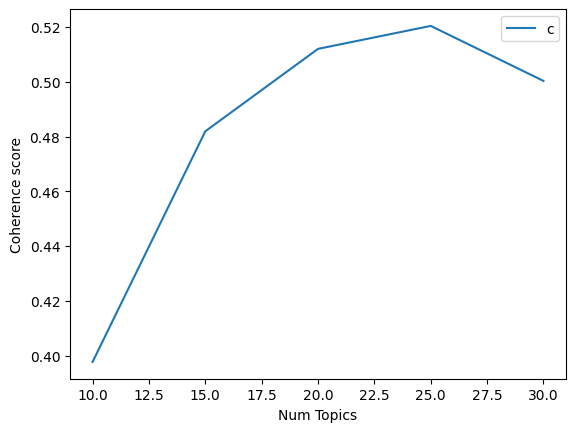

In [22]:
limit=35; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.3977
Num Topics = 15  has Coherence Value of 0.4819
Num Topics = 20  has Coherence Value of 0.512
Num Topics = 25  has Coherence Value of 0.5204
Num Topics = 30  has Coherence Value of 0.5003


### The optimal number of topics was 25

In [93]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(13,
  '0.067*"millone" + 0.027*"posible" + 0.026*"exportacion" + 0.026*"en" + '
  '0.023*"restriccione" + 0.021*"gross" + 0.021*"dolare" + '
  '0.018*"preocupacion" + 0.017*"entre" + 0.012*"comunicacion"'),
 (14,
  '0.113*"integrate" + 0.056*"papua" + 0.046*"farm" + 0.029*"northeast" + '
  '0.007*"green_light" + 0.004*"nexus" + 0.000*"republic" + 0.000*"guinea" + '
  '0.000*"congo" + 0.000*"sao_tome"'),
 (24,
  '0.264*"die" + 0.091*"und" + 0.031*"fur" + 0.031*"m" + 0.028*"sind" + '
  '0.025*"auch" + 0.018*"haben" + 0.017*"mit" + 0.016*"hat" + 0.015*"der"'),
 (11,
  '0.336*"apple" + 0.059*"code" + 0.022*"new" + 0.020*"device" + '
  '0.018*"new_york" + 0.018*"state" + 0.018*"island" + 0.014*"macdailynew" + '
  '0.011*"shopping" + 0.009*"tech"'),
 (18,
  '0.131*"que" + 0.042*"por" + 0.034*"tomb" + 0.033*"archaeologist" + '
  '0.028*"social_science" + 0.025*"segun" + 0.023*"estadounidense" + '
  '0.022*"archaeology" + 0.020*"este" + 0.019*"para"'),
 (9,
  '0.070*"debt" + 0.051*"loan" + 0

In [108]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    #sent_topics_df = pd.DataFrame()
    top_list = []

    # Get main topic in each document
    for i, row in enumerate(list(ldamodel[corpus])):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                #temp = pd.DataFrame([int(topic_num), round(prop_topic,4), topic_keywords], columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
                #sent_topics_df = pd.concat([sent_topics_df, temp])
                top_list.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break
    sent_topics_df = pd.DataFrame(top_list, columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

## Finding the dominant topic in each document

In [109]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,21,0.3026,"technology, new, system, power, develop, use, ...","In the new Sino-Russian defense relationship, ..."
1,1,22,0.9810,"advertisement, insider, use, cookie, website, ...",Cookie Preferences Cookie List Cookie List A c...
2,2,16,0.3362,"say, report, year, chinese, accord, last, also...","In this image made from video, Chinese Foreign..."
3,3,19,0.8039,"people, say, city, covid, year, child, new, de...",Associated Press BEIJING — Heavy flooding has ...
4,4,12,0.4662,"tiktok, climate, meet, getty_image, bytedance,...","El presidente estadounidense, Joe Biden, afirm..."
5,5,19,0.5014,"people, say, city, covid, year, child, new, de...",BEIJING — China on Saturday reported nearly 60...
6,6,8,0.6479,"year, economy, growth, market, economic, month...",Oil tankers sail along Nakhodka Bay near the p...
7,7,4,0.3017,"war, russian, military, peace, conflict, say, ...",U.S. National Security Adviser Jake Sullivan s...
8,8,13,0.4442,"millone, posible, exportacion, en, restriccion...","La secretaria del Tesoro de Estados Unidos, Ja..."
9,9,15,0.3414,"say, official, chinese, visit, united_state, t...",A Chinese fighter jet swerved in front of a U....


# Create tree representation

In [131]:
data_lemmatized[2]

['image',
 'make',
 'video',
 'chinese',
 'foreign',
 'gesture',
 'speak',
 'medium',
 'affair']

In [165]:
optimal_model[corpus][2][2]

[(52, [(0, 0.06705839), (7, 0.3315415), (16, 0.58954024)]),
 (140, [(0, 0.87291855), (7, 0.09966193), (17, 0.019863404)]),
 (206, [(0, 0.033399068), (7, 0.49732068), (16, 0.46295094)]),
 (433, [(0, 0.619291), (7, 0.06488753), (16, 0.31381297)]),
 (434, [(18, 0.99883646)]),
 (435, [(7, 0.29551893), (16, 0.702663)]),
 (436, [(7, 0.018023565), (16, 0.9394712), (18, 0.041748017)]),
 (437, [(7, 0.18941449), (15, 0.01024905), (16, 0.7938402)]),
 (438, [(6, 0.99820274)])]

In [68]:
data_lemmatized[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

In [ ]:
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

In [ ]:
doc = nlp(data[0])
[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

In [85]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))